# Processing data from Couturier2019.PRA.99.022503

Measurement of the strontium triplet Rydberg series by depletion spectroscopy of ultracold atoms
Luc Couturier, Ingo Nosske, Fachao Hu, Canzhu Tan, Chang Qiao, Y. H. Jiang, Peng Chen, and Matthias Weidemüller
Phys. Rev. A 99, 022503 (2019)
https://doi.org/10.1103/PhysRevA.99.022503

In [1]:
import os
import glob

import pandas as pd
import numpy as np
from uncertainties import ufloat, unumpy

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')

## Constants
Constants to be set for each particular data set.

In [2]:
# Constants that should not need changing
C = 299792458 # Speed of light in [m/s]

# CODATA 2014 constants
RY_inf = ufloat(10973731.568508, 0.000065)/100 # Rydberg constant [/cm]
AMU = ufloat(1.660539040, 0.000000020)*1E-27 # Atomic mass unit [kg]
M_E = ufloat(9.10938356, 0.00000011)*1E-31 # Electron mass [kg]

M_88 = ufloat(87905612.256, 0.006)*1E-6*AMU
M_87 = ufloat(86908877.496, 0.005)*1E-6*AMU
M_86 = ufloat(85909260.726, 0.006)*1E-6*AMU
M_84 = ufloat(83913419.1, 1.3)*1E-6*AMU

out = pd.DataFrame(columns=['Series','n', 'Term', 'Label', 'E_exp', 'E_exp_unc', 'Isotope', 'Reference'])

In [3]:
# Constants which should change depending on the data set being analyzed
REFERENCE = 'Couturier2019.PRA.99.022503'
PATH_TO_RAW_DATA = os.path.join('source','Couturier2019.PRA.99.022503*.csv')
OUTPUT_FILE_NAME = REFERENCE + '-analyzed.csv'

ISOTOPE = 88

I_S = ufloat(1377012721, 10)/(C*100/1E6) # Given ionization limit for 88Sr in paper.

#RY_Sr = 109736.631 # Rydberg constant in [/cm]
RY_Sr = RY_inf*(M_88/(M_E + M_88))

## Read in all the files to a single DataFrame

In [6]:
# Goes through all listed .csv files and returns data in a single DataFrame

source_list = glob.glob(PATH_TO_RAW_DATA)

def gather_data(file_list):
    
    # Read in .csv files in to single DataFrame
    out = pd.DataFrame()
    for file_name in file_list:
        df = pd.read_csv(file_name)
        
        out = pd.concat([out, df], join='outer', ignore_index=True, sort=False)
    
    return out

data = gather_data(source_list)

## Process data
May need to tweak depending on the data set being analyzed.

In [7]:
# The paper gives 10 MHz uncertainty for all their data.
data['E_exp_unc [MHz]'] = 10

# Convert energy in [MHz] to [/cm] and add to DataFrame
E_expt = unumpy.uarray(data['E_exp [MHz]'], data['E_exp_unc [MHz]'])
E_expt = E_expt/(C*100/1E6)

data['E_exp'] = unumpy.nominal_values(E_expt)
data['E_exp_unc'] = unumpy.std_devs(E_expt)

### Put data in to a standardized table

In [8]:
# Only keep data that's newly presented (some data tables include previously measured data)
out['Term'] = data[data['New'] & ~pd.isna(data['New'])]['Series']
out['n'] = data[data['New'] & ~pd.isna(data['New'])]['n']
out['E_exp'] = data[data['New'] & ~pd.isna(data['New'])]['E_exp']
out['E_exp_unc'] = data[data['New'] & ~pd.isna(data['New'])]['E_exp_unc']

# Set the isotope
out['Isotope'] = ISOTOPE
out['Reference'] = REFERENCE

# Specify the series based on the term
for idx, row in out.iterrows():
    if row['Term'] == '3S1':
        out.at[idx, 'Series'] = '5sns'
    elif row['Term'] == '1D2' or row['Term'] == '3D1' or row['Term'] == '3D2' or row['Term'] == '3D3':
        out.at[idx, 'Series'] = '5snd'
    else:
        print('Error with assigning series')

# Label the states
for idx, row in out.iterrows():
    out.at[idx, 'Label'] = row['Series'].replace('n', str(row['n']))

### Calculate quantum defect

In [9]:
n = out['n']
E_exp = unumpy.uarray(out['E_exp'], out['E_exp_unc'])
delta_expt = n - unumpy.sqrt(RY_Sr/(I_S-E_exp))

out['delta_exp'] = unumpy.nominal_values(delta_expt)
out['delta_exp_unc'] = unumpy.std_devs(delta_expt)

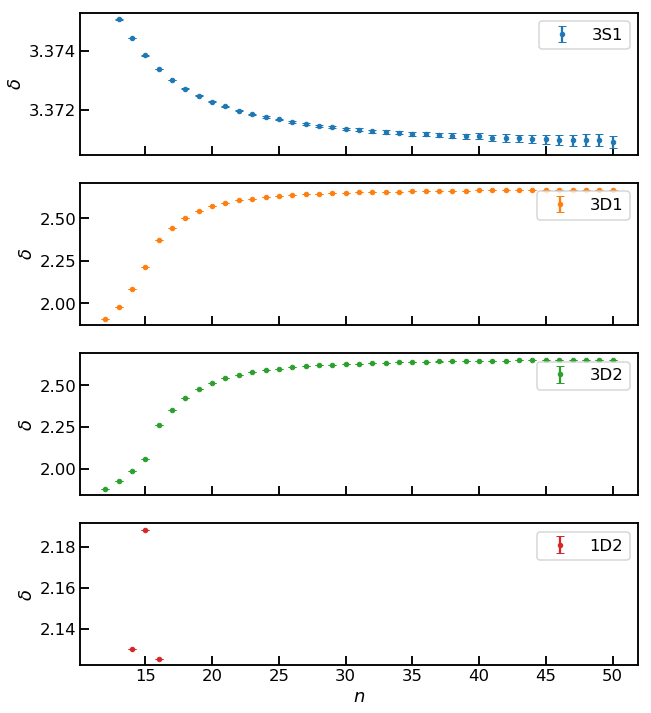

In [10]:
plt_kwargs = {'capsize':4,
              'fmt':'.'}

nrows = len(out['Term'].unique())

if nrows > 1:
    [fig, axs] = plt.subplots(nrows=nrows, ncols=1, figsize=(10,3*nrows), sharex=True, sharey=False)

    for i, T in enumerate(out['Term'].unique()):
        x = out[out['Term'] == T]['n']
        y = out[out['Term'] == T]['delta_exp']
        yerr = out[out['Term'] == T]['delta_exp_unc']
        axs[i].errorbar(x, y, yerr=yerr, label=T, **plt_kwargs, color=sns.color_palette()[i])
        axs[i].legend()
        axs[i].tick_params(axis='both', direction='in')
        axs[i].set_ylabel(r'$\delta$')

    plt.xlabel(r'$n$')
    plt.show()

else:
    plt.figure(figsize=(10,3))
    
    T = out['Term'].unique()[0]
    
    x = out['n']
    y = out['delta_exp']
    yerr = out['delta_exp_unc']
    plt.errorbar(x, y, yerr=yerr, label=T, **plt_kwargs, color=sns.color_palette()[0])
    plt.legend()
    plt.gca().tick_params(axis='both', direction='in')

    plt.xlabel(r'$n$')
    plt.ylabel(r'$\delta$')
    plt.show()

### Write out processed data as .csv

In [11]:
out.to_csv(OUTPUT_FILE_NAME, index=False)